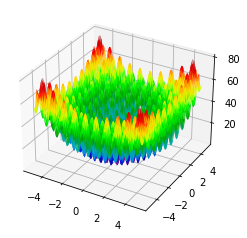

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 

def rastrigin(x,y):
    return (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y)) + 20

X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
 
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.savefig('rastrigin_graph.png')
plt.show()

In [19]:
import functools
import random
def chromosome_to_xy(chromosome):
    x = functools.reduce(lambda acc,x: (acc + 2**(2-x[0])) if x[1] else acc,enumerate(chromosome[:chromosome.size//2]),-3.769)
    y = functools.reduce(lambda acc,x: (acc + 2**(2-x[0])) if x[1] else acc,enumerate(chromosome[chromosome.size//2:]),-3.769)
    return x,y

def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        x,y = chromosome_to_xy(chromosome)
        scores.append(-rastrigin(x,y))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        point = random.randint(0, len(child))
        child[point:]=pop_after_sel[(i+1)%len(pop_after_sel)][point:]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
#         print(scores[:2])
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [30]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score=generations(size=2000,n_feat=30,n_parents=100,mutation_rate=0.03,
                     n_gen=100)

In [60]:
from operator import itemgetter
best = max(zip(chromo,score), key=itemgetter(1))
best

(array([False,  True,  True,  True,  True, False, False, False,  True,
        False,  True, False,  True,  True, False, False,  True,  True,
         True,  True, False, False, False,  True, False, False,  True,
         True,  True, False]),
 -0.0007908274876058385)

In [40]:
bestindex = score.index(best[1])

-0.0007908274876058385

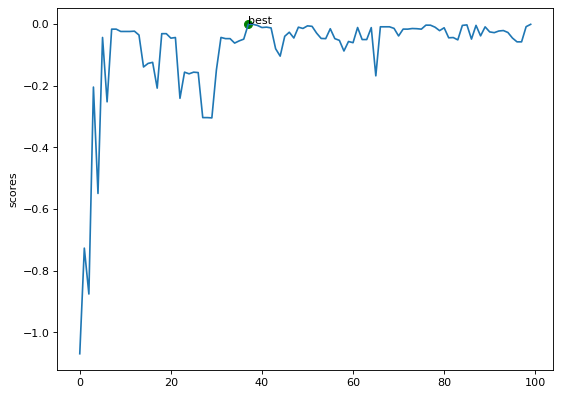

In [55]:
plt.figure(figsize=(8, 6), dpi=80) 
plt.plot(score)
plt.scatter(bestindex, score[bestindex],color="g",s=50)
plt.annotate("best", (bestindex,score[bestindex]))
plt.ylabel('scores')
plt.show()

In [56]:
x,y = chromosome_to_xy(best[0])
print(f"Final value[{x},{y}] = {rastrigin(x,y)}")

Final value[0.001996093749999872,4.29687499998721e-05] = 0.0007908274876058385


In [57]:
points = [chromosome_to_xy(ch) for ch in chromo]
x_r = [x[0] for x in points]
y_r = [x[1] for x in points]
z_r = [ rastrigin(x,y) for x,y in points]

In [58]:
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20

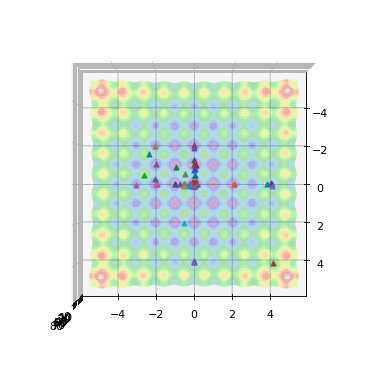

In [59]:
from IPython.display import HTML
from matplotlib import animation
frames = 200
fig = plt.figure(figsize=(8, 6), dpi=80) 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.nipy_spectral, linewidth=0.08,antialiased=True, alpha=0.3)    
ax.view_init(90, 0)
    
def animate(frame):
    start = len(x_r)*(frame-1)//frames
    end = len(x_r)*frame//frames
    if start != end:
        ax.scatter(x_r[start:end], y_r[start:end], z_r[start:end], marker="^")
#     plt.pause(.1)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=50)
HTML(anim.to_html5_video())

In [61]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score=generations(size=2000,n_feat=30,n_parents=100,mutation_rate=0.1,
                     n_gen=100)

In [62]:
from operator import itemgetter
best = max(zip(chromo,score), key=itemgetter(1))
best

(array([ True, False,  True,  True,  True, False, False, False,  True,
        False,  True,  True, False, False, False, False,  True,  True,
         True,  True, False, False, False, False,  True, False, False,
        False,  True,  True]),
 -0.05298640934612564)

In [63]:
bestindex = score.index(best[1])

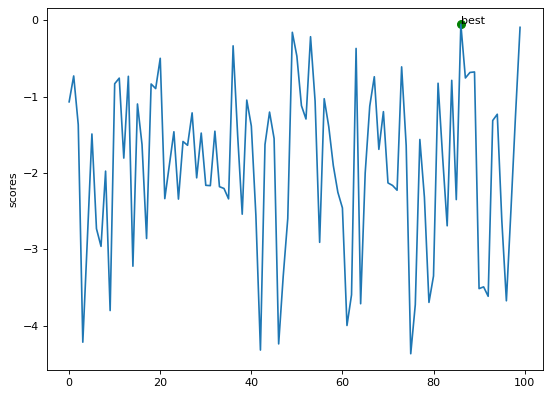

In [64]:
plt.figure(figsize=(8, 6), dpi=80) 
plt.plot(score)
plt.scatter(bestindex, score[bestindex],color="g",s=50)
plt.annotate("best", (bestindex,score[bestindex]))
plt.ylabel('scores')
plt.show()

In [65]:
x,y = chromosome_to_xy(best[0])
print(f"Final value[{x},{y}] = {rastrigin(x,y)}")

Final value[2.002484375,-0.010455078125000128] = 4.032840189792434
